In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_5996/1124589693.py:9: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


In [6]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [7]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
    
        return 0

In [8]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [9]:
df_1 = data.loc['2010-01-01':'2013-01-01']
df_valid = data.loc['2013-04-01':'2013-07-01']
df_test = data.loc['2013-07-01':'2013-10-01']

In [10]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [11]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

## Importing Optuna and suppressing warning messages

In [12]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

## Defining the Optuna objective function

In [13]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',800,2400,step=800)
    rf_max_depth = trial.suggest_int('max_depth',4,15)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    accuracy = rf_clf.score(val,val_labels)
 
    return accuracy

In [14]:
study = optuna.create_study(direction="maximize")

In [15]:
from functools import partial

In [16]:
%%time
study.optimize(partial(objective,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=200,n_jobs=-1)

CPU times: user 59.4 s, sys: 6.84 s, total: 1min 6s
Wall time: 13 s


In [17]:
study.best_params

{'n_estimators': 15,
 'max_features': 'log2',
 'min_samples_leaf': 800,
 'max_depth': 8}

In [18]:
rf_clf = RandomForestClassifier(**study.best_params)

In [19]:
rf_clf.fit(train_1,y_1)

RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=800,
                       n_estimators=15)

In [20]:
preds=rf_clf.predict(valid)

In [21]:
valid_profit = (preds * df_valid['next_period_return']).sum()
valid_profit

125.59496

In [22]:
pred_test=rf_clf.predict(test)

In [23]:
test_profit = (pred_test * df_test['next_period_return']).sum()
test_profit

99.95234299999996

In [24]:
confusion_matrix(y_test,pred_test)

array([[ 17,   0, 772],
       [  8,   0, 154],
       [ 20,   0, 830]])

In [25]:
accuracy_score(preds,y_valid)

0.49314285714285716

In [26]:
accuracy_score(pred_test,y_test)

0.470294280955025

In [27]:
len(train_1.columns)

725

In [28]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [29]:
fi = randomforest_feat_importances(rf_clf,train_1)

In [30]:
features = fi[(fi['feat_imp'] > 0.00)]

In [31]:
features.shape

(60, 2)

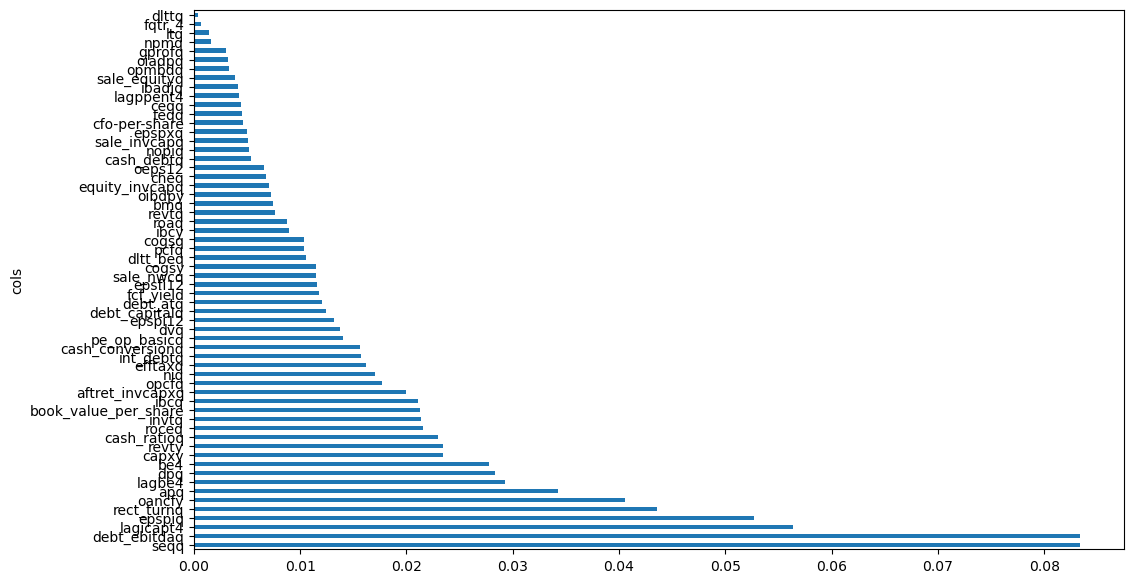

In [32]:
plot_fi(features);

In [33]:
features

,cols,feat_imp
53,seqq,0.083333
147,debt_ebitdaq,0.083333
127,lagicapt4,0.056352
22,epspiq,0.052666
171,rect_turnq,0.043531
76,oancfy,0.040534
1,apq,0.034249
125,lagbe4,0.029309
15,dpq,0.028310
124,be4,0.027758


In [34]:
train_1 = train_1[features['cols'].values]
valid = valid[features['cols'].values]

In [35]:
rf_clf.fit(train_1,y_1)
rf_clf.score(train_1,y_1)

0.5079708937399322

In [36]:
len(valid)

1750

In [37]:
pred_valid = rf_clf.predict(valid)
rf_clf.score(valid,y_valid)

0.4685714285714286

In [38]:
(pred_valid * valid_stock_returns).sum()

80.60010800000003

In [39]:
Counter(pred_valid)

Counter({1: 1484, -1: 266})

In [40]:
valid_1 = valid.copy()

In [41]:
valid_1['returns'] = valid_stock_returns.values

In [42]:
import shap

In [43]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [44]:
model(valid_1)

0      -0.003409
1      -0.006907
2       0.041883
3      -0.029884
4       0.128291
          ...   
1745   -0.119765
1746    0.153591
1747    0.108772
1748    0.137032
1749    0.152459
Name: returns, Length: 1750, dtype: float64

In [45]:
explainer = shap.explainers.Permutation(model,valid_1)

In [46]:
shap_values = explainer(valid_1,max_evals=2000)

PermutationExplainer explainer: 1751it [03:57,  7.08it/s]                       


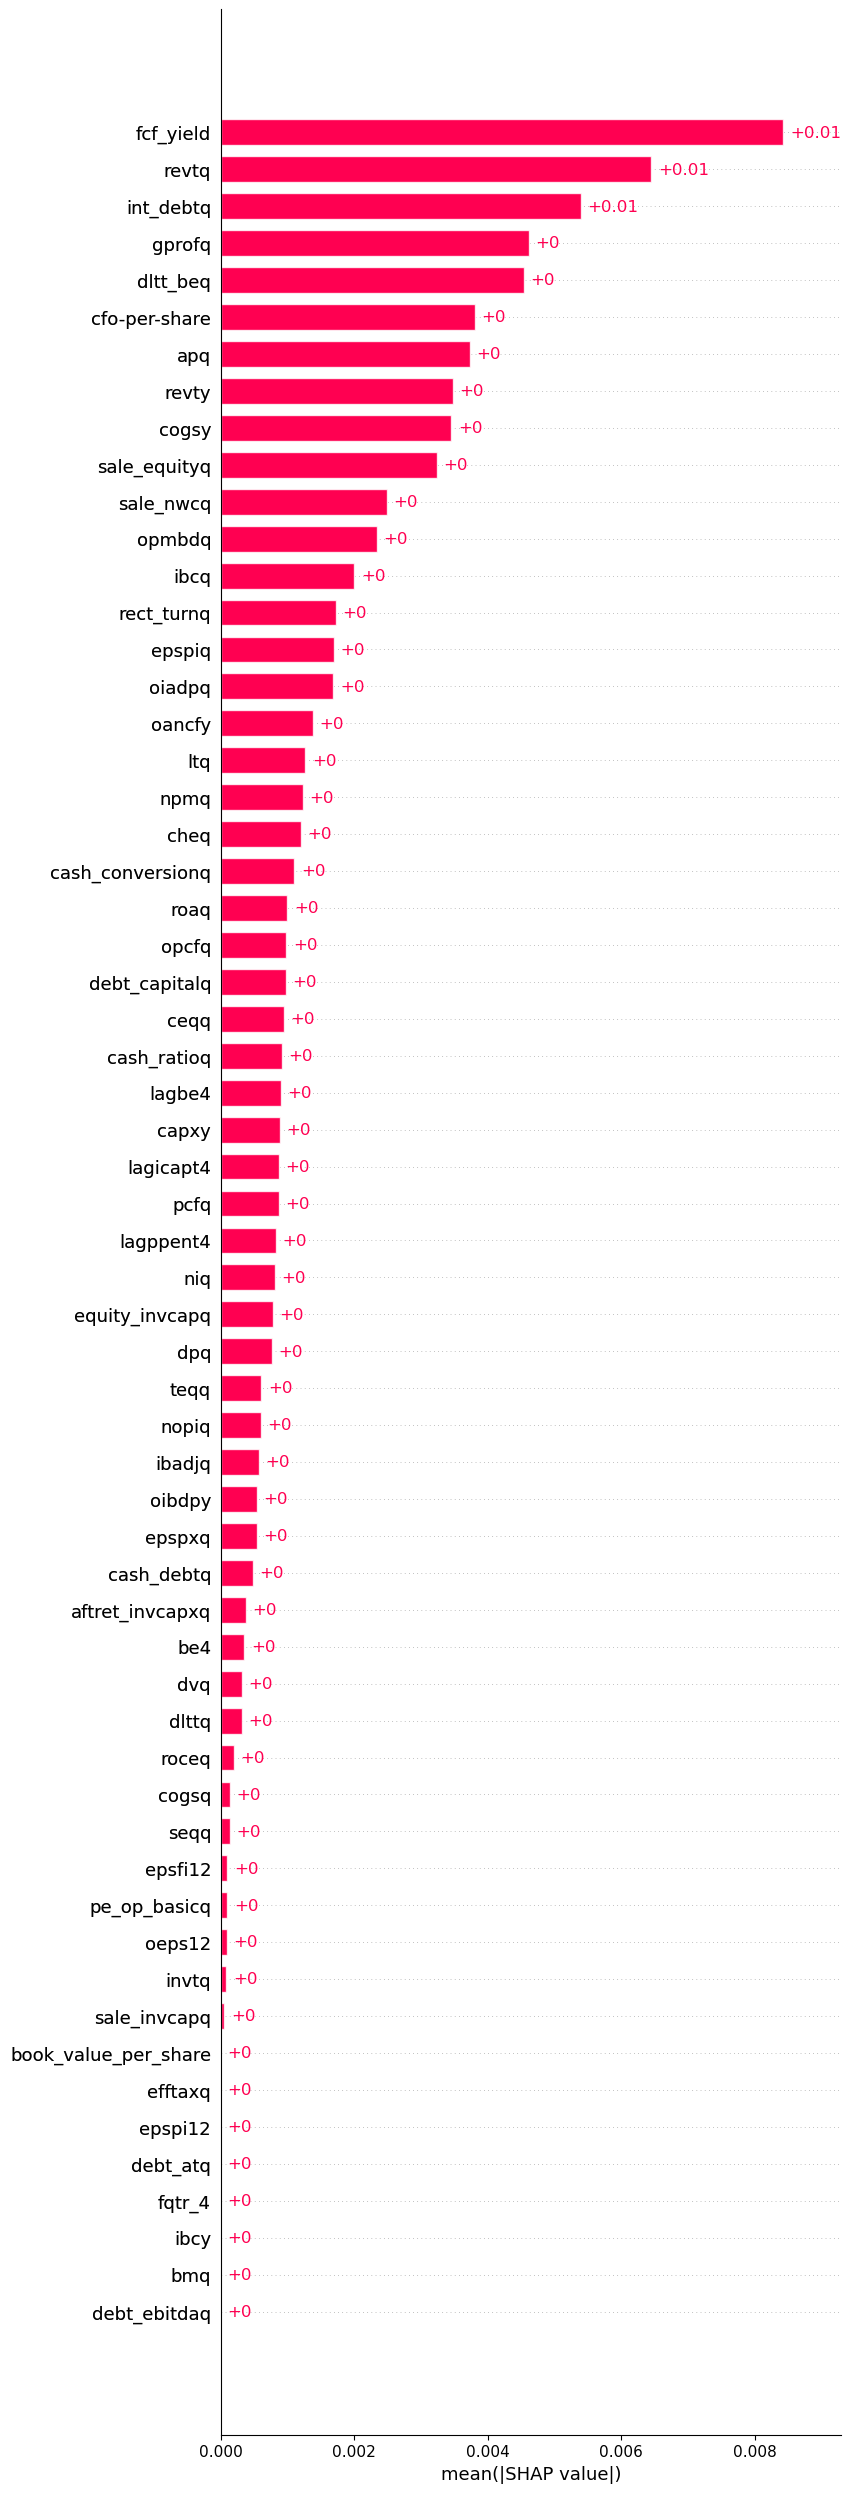

In [47]:
shap.plots.bar(shap_values[:,:-1],max_display=60)

In [48]:
cols = features['cols'].values

In [49]:
shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]

In [50]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [76]:
end_dates

[Timestamp('2004-01-01 00:00:00'),
 Timestamp('2004-04-01 00:00:00'),
 Timestamp('2004-07-01 00:00:00'),
 Timestamp('2004-10-01 00:00:00'),
 Timestamp('2005-01-01 00:00:00'),
 Timestamp('2005-04-01 00:00:00'),
 Timestamp('2005-07-01 00:00:00'),
 Timestamp('2005-10-01 00:00:00'),
 Timestamp('2006-01-01 00:00:00'),
 Timestamp('2006-04-01 00:00:00'),
 Timestamp('2006-07-01 00:00:00'),
 Timestamp('2006-10-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-04-01 00:00:00'),
 Timestamp('2007-07-01 00:00:00'),
 Timestamp('2007-10-01 00:00:00'),
 Timestamp('2008-01-01 00:00:00'),
 Timestamp('2008-04-01 00:00:00'),
 Timestamp('2008-07-01 00:00:00'),
 Timestamp('2008-10-01 00:00:00'),
 Timestamp('2009-01-01 00:00:00'),
 Timestamp('2009-04-01 00:00:00'),
 Timestamp('2009-07-01 00:00:00'),
 Timestamp('2009-10-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2010-04-01 00:00:00'),
 Timestamp('2010-07-01 00:00:00'),
 Timestamp('2010-10-01 00:00:00'),
 Timestamp('2011-01-

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [75]:
shap_cols

array(['seqq', 'lagicapt4', 'epspiq', 'rect_turnq', 'oancfy', 'apq',
       'lagbe4', 'dpq', 'be4', 'capxy', 'revty', 'cash_ratioq', 'roceq',
       'invtq', 'ibcq', 'aftret_invcapxq', 'opcfq', 'niq', 'int_debtq',
       'cash_conversionq', 'pe_op_basicq', 'dvq', 'debt_capitalq',
       'fcf_yield', 'epsfi12', 'sale_nwcq', 'cogsy', 'dltt_beq', 'pcfq',
       'cogsq', 'roaq', 'revtq', 'oibdpy', 'equity_invcapq', 'cheq',
       'oeps12', 'cash_debtq', 'nopiq', 'sale_invcapq', 'epspxq',
       'cfo-per-share', 'teqq', 'ceqq', 'lagppent4', 'ibadjq',
       'sale_equityq', 'opmbdq', 'oiadpq', 'gprofq', 'npmq', 'ltq',
       'dlttq'], dtype=object)

In [53]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        rf_clf.fit(opt_training_data[i],training_labels[i])

        preds = rf_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)


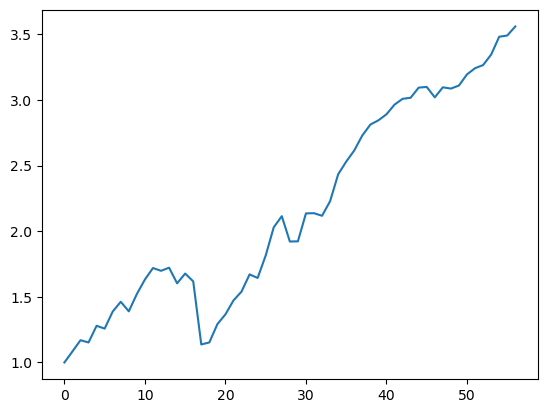

In [54]:
plt.plot(x);

In [56]:
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2004-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x

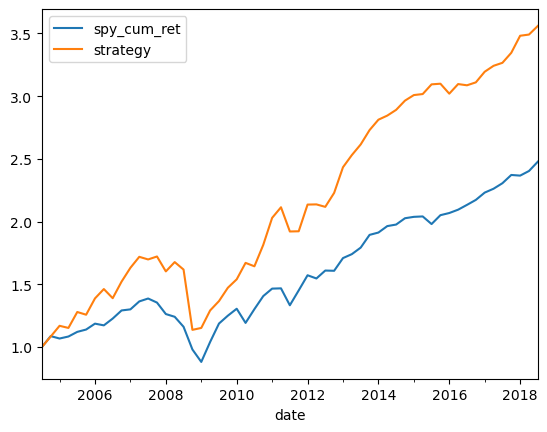

In [57]:
SPY.plot();

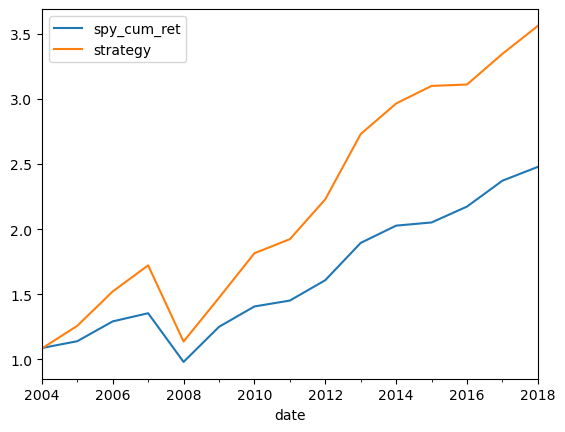

In [58]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [59]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7108291409172046


In [60]:
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_std

0.24878733270882064

In [61]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.6324646748042164


In [62]:
x[-1]

3.559894889489913

In [63]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

1.6111286649688186

In [64]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.20829487410465192

In [65]:
alpha = np.mean(residual_ret)
alpha

0.016819586090609004

In [66]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(100):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [67]:
def randomforest_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [68]:
pi = randomforest_profit_importance(rf_clf,valid,valid_stock_returns)
pi

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- bmq
- book_value_per_share
- debt_atq
- debt_ebitdaq
- efftaxq
- ...


In [ ]:
%%time
profits = []
feat=[]

train = train_1.copy()
validation = valid.copy()

while len(train.columns)>1:

    col_to_drop = pi.iloc[-1]['cols']
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)
        
    rf_clf.fit(train,y_1)
    pi = randomforest_profit_importance(rf_clf,validation,df_valid['next_period_return'])

    pred_valid = rf_clf.predict(validation)
        
    print((pred_valid * df_valid['next_period_return']).sum())
    profits.append((pred_valid * df_valid['next_period_return']).sum())
    feat.append(train.columns)

In [69]:
plt.plot(profits);

NameError: name 'profits' is not defined

In [70]:
n = np.argmax(profits)
profits[n]

NameError: name 'profits' is not defined

In [71]:
n

NameError: name 'n' is not defined

In [72]:
optim_feats = feat[n]
optim_feats


NameError: name 'feat' is not defined

In [73]:
train_1_optim = train_1[optim_feats]
valid_optim = valid[optim_feats]


rf_clf.fit(train_1_optim,y_1)
print(rf_clf.score(train_1_optim,y_1))
pred_valid = rf_clf.predict(valid_optim)
print(rf_clf.score(valid_optim,y_valid))
(pred_valid * valid_stock_returns).sum()

NameError: name 'optim_feats' is not defined

In [74]:
confusion_matrix(pred_valid,y_valid)

array([[ 89,  11, 166],
       [  0,   0,   0],
       [650, 103, 731]])

In [ ]:
Counter(y_valid)

In [ ]:
Counter(pred_valid)

## Long term performance with Random Forest Classifier, optimal hyper-parameters

In [ ]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [ ]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [ ]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [ ]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [ ]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [ ]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [ ]:
opt_training_data

In [ ]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        rf_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = rf_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

In [ ]:
plt.plot(x);

In [ ]:
len(x)

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-01-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

In [ ]:
x[-1]

In [ ]:
SPY['spy_cum_ret'][-1]

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [ ]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [ ]:
beta

In [ ]:
residual_ret = strategy_ret - beta * spy_ret

In [ ]:
IR = np.mean(residual_ret)/np.std(residual_ret)

In [ ]:
IR

In [ ]:
alpha = np.mean(residual_ret)

In [ ]:
alpha

## Compute optimal features each quarter

In [ ]:
import _pickle as cPickle

In [ ]:
with open(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 5\opt_feat_4.pkl','rb') as f:
    optimal_features = cPickle.load(f)

In [ ]:
optimal_features

In [ ]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [ ]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [ ]:
optimal_features

In [ ]:
len(optimal_features)

In [ ]:
rf_clf = RandomForestClassifier(**{'n_estimators': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1600,
 'max_depth': 10})

In [ ]:
P_L = []
x = [1]
ret = []

for i in range(len(optimal_features)-1):
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

In [ ]:
plt.plot(x[1:]);

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-07-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [ ]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

## Compute both optimal hyper-parameters and optimal features at each quarter

In [ ]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 35) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
validation_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
validation_data = test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in validation_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in validation_frames]

In [ ]:
len(data.columns)

In [ ]:
%%time
optimal_features = []
classifiers = []

for i in range(len(training_data)):
    print(i)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(partial(objective,train=training_data[i],
                           labels=training_labels[i],
                           val=validation_data[i],
                           val_labels=validation_labels[i],
                           val_rets = validation_frames[i]['next_period_return']),
                           n_trials=100,n_jobs=-1)
    params = study.best_params
    
    print(params)
    
    rf_clf = RandomForestClassifier(**params)

    classifiers.append(rf_clf)
    
    rf_clf.fit(training_data[i],training_labels[i])
    fi = randomforest_feat_importances(rf_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.005]
    
    train = training_data[i][features['cols'].values].copy()
    validation = validation_data[i][features['cols'].values].copy()
    
    
    profits = []
    feat=[]
    
    rf_clf.fit(train,training_labels[i])
    
    while len(train.columns)>1:
        
        pi = randomforest_profit_importance(rf_clf,validation,validation_frames[i]['next_period_return'])

        col_to_drop = pi.iloc[-1]['cols']
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        
        rf_clf.fit(train,training_labels[i])
        pred_valid = rf_clf.predict(validation)
        profits.append((pred_valid * validation_frames[i]['next_period_return']).sum())
        feat.append(train.columns)
        
    n = np.argmax(profits)

    max_profits = profits[n]

    optim_feats = feat[n]
    
    print(optim_feats)
    print(max_profits)

    optimal_features.append(optim_feats)

In [ ]:
with open('opt_feat_11.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [ ]:
with open('classifiers_11.pkl','rb') as f:
    classifiers = pickle.load(f)

In [ ]:
P_L = []
x = [1]
ret = []

for i in range(len(optimal_features)-1):

        classifiers[i-1].fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = classifiers[i-1].predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

In [ ]:
plt.plot(x);

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-07-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
SPY.tail()

In [ ]:
SPY = SPY.resample('A').bfill()

In [ ]:
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

In [ ]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

In [ ]:
avr = np.exp(np.log(x[-1])/15.) - 1
print('Average annual return: ',avr)
sp_avr = np.exp(np.log(SPY['spy_cum_ret'][-1])/15) - 1
print('SPY average annual return: ', sp_avr)

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
print('beta: ',beta)
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
print('Information Ratio: ',IR)

In [ ]:
alpha = np.mean(residual_ret)
print('Strategy alpha: ',alpha)

In [ ]:
starting_year='2010'
a = SPY.loc[starting_year]['spy_cum_ret'].values
b = SPY.loc[starting_year]['strategy'].values
plt.plot(SPY.loc[starting_year:]['spy_cum_ret'] - a + 1);
plt.plot(SPY.loc[starting_year:]['strategy'] - b + 1);

In [ ]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [ ]:
max_drawdown(SPY['strategy'])

In [ ]:
max_drawdown(SPY['spy_cum_ret'])